# Input Data to Dataframe
Pre-process the data so that each sample is in a sequential dataframe, with each row containing the sensor data for that point.

In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import pickle
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
#import torchinfo
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation

In [2]:
# Get global stats
df_gs_sw = pd.read_csv("./inputs_global_stats.csv")

with open("/root/data/smartwatch/analysis/mocap_global_stats.pkl", "rb") as f:
    mocap_global_counters = pickle.load(f)

mocap_global_stats = {}
for key, counter in mocap_global_counters.items():
    N = sum(counter.values())
    mu = sum([val * count for val, count in counter.items()]) / N
    sigma = np.sqrt(sum([(val - mu) ** 2 * count for val, count in counter.items()]) / N)
    mocap_global_stats[key] = {"mean": mu, "std": sigma}

# Get start and stop times from mocap data
df_mtimes = pd.read_csv("/root/data/smartwatch/analysis/mocap_valid_times.csv")

In [3]:
import itertools

def load_mocap_df(fp):
    # Read the header of the file to get columns and frequency info
    with open(fp, 'r') as f:
        old_line = ""
        new_line = ""
        frequency = None
        for skip_lines, new_line in enumerate(f):
            if len(old_line.split(",")) > 5:
                break  # Stop when we encounter the first very long header row
            if old_line.lower().strip() == "trajectories":
                frequency = float(new_line.split(",")[0])  # Sometimes frequency has ",hz" on the same line
            old_line = new_line
    header = old_line.split(",")
    header_markers = [col.split(':')[-1] for col in header]
    # We need radial styloid (RS), ulnar styloid (US), medial epicondyle (ME), and lateral epicondyle (LE)
    # for computing forearm orientation and positions
    markers = ["R_RS", "R_US", "R_ME", "R_LE"]
    col_names = [f"{marker}_{axis}" for marker, axis in itertools.product(markers, "XYZ")]
    col_inds = []
    for marker in markers:
        i = header_markers.index(marker)
        col_inds.extend([i, i+1, i+2])  

    # Sort by names by index, pandas usecols arg uses sorted column order
    col_inds, col_names = list(zip(*sorted(zip(col_inds, col_names))))

    df = pd.read_csv(fp, skiprows=skip_lines + 2, usecols=col_inds, names=col_names)
    df.index = pd.to_timedelta(df.index / frequency, unit="seconds")
    df = df.resample("0.02S").mean()  # Resample to 50 Hz
    return df

def process_mocap_file(df, positive_qw=True):
    df = df.dropna(axis=0)  # For stats, drop NA rows

    # Get marker positions
    p_rs = df.loc[:, ["R_RS_X", "R_RS_Y", "R_RS_Z"]].values
    p_us = df.loc[:, ["R_US_X", "R_US_Y", "R_US_Z"]].values
    p_me = df.loc[:, ["R_ME_X", "R_ME_Y", "R_ME_Z"]].values
    p_le = df.loc[:, ["R_LE_X", "R_LE_Y", "R_LE_Z"]].values
    
    # Compute landmark vectors
    o_w = p_us
    p_elbow = (p_le + p_me) / 2

    y_w = p_elbow - p_us
    v_1 = p_rs - p_us
    x_w = np.cross(y_w, v_1, axis=-1)
    z_w = np.cross(x_w, y_w, axis=-1)

    # Unit axis vectors
    e_x = x_w / np.linalg.norm(x_w, axis=-1).reshape(-1, 1)
    e_z = z_w / np.linalg.norm(z_w, axis=-1).reshape(-1, 1)
    e_y = y_w / np.linalg.norm(y_w, axis=-1).reshape(-1, 1)

    # Rotation matrix
    R = np.stack([e_x, e_y, e_z], axis=1)
    # Convert to quaternion
    rot = Rotation.from_matrix(R)
    quat = rot.as_quat()
    # Force qw to be positive, quaternions are equivalent up to the sign
    if positive_qw:
        sign = np.sign(quat[:, -1]).reshape(-1, 1)
        quat = quat * sign

    # Combine centered position and quaternion
    o_w = o_w - o_w.mean(axis=0)
    o_w = np.round(o_w, decimals=0)
    quat = np.round(quat, decimals=3)
    features = np.hstack([o_w, quat])

    return pd.DataFrame(features, columns=["X", "Y", "Z", "qx", "qy", "qz", "qw"])

In [22]:
def process_full_df(df_imu, df_m, subject):
    
    # Rename sensors
    df_imu.loc[df_imu[" Sensor Type"] == 1, " Sensor Type"] = "Accelerometer"
    df_imu.loc[df_imu[" Sensor Type"] == 2, " Sensor Type"] = "Magnetometer"
    df_imu.loc[df_imu[" Sensor Type"] == 4, " Sensor Type"] = "Gyroscope"
    subdfs = [df_imu.loc[df_imu[" Sensor Type"] == sensor_type, :] for sensor_type in df_imu[" Sensor Type"].unique()]

    # Crop start and end times based on mocap timing
    mtime = df_mtimes.loc[df_mtimes['file'] == subject]
    subdfs = [subdf.loc[subdf.index[(subdf['Sample Time [s]'] >= mtime['start'].iloc[0]) & (subdf['Sample Time [s]'] <= mtime['end'].iloc[0])]] for subdf in subdfs]
    mask = (df_m.index >= pd.Timedelta(mtime['start'].iloc[0], unit="s")) & (df_m.index <= pd.Timedelta(mtime['end'].iloc[0], unit="s"))
    df_m = df_m[mask]
    df_m = df_m.interpolate(method="linear", axis=0, limit_area="inside")
    df_m = df_m.dropna(axis=0)

    # Find latest start time and earliest end time across sensor types
    max_start = max([min(max([subdf['Sample Time [s]'] for subdf in subdfs], key=min)), df_m.index.total_seconds().min()])
    min_end = min([max(min([subdf['Sample Time [s]'] for subdf in subdfs], key=max)), df_m.index.total_seconds().max()])
    #max_ends.append(max(max([subdf['Sample Time [s]'] for subdf in subdfs], key=max)))

    # Crop data to be within the same range 
    subdfs = [subdf.loc[subdf.index[(subdf['Sample Time [s]'] >= max_start) & (subdf['Sample Time [s]'] <= min_end)]] for subdf in subdfs]
    mask = (df_m.index >= pd.Timedelta(max_start, unit="s")) & (df_m.index <= pd.Timedelta(min_end, unit="s"))
    df_m = df_m[mask]
    
    # Fill inner missing values, often just single missing values
    df_m = df_m.interpolate(method="linear", axis=0, limit_area="inside")
    df_m = df_m.dropna(axis=0)


    # Resample each smartwatch series (using time deltas)
    for i, subdf in enumerate(subdfs):
        subdf.index = pd.to_timedelta( subdf['Sample Time [s]'], unit="seconds")
        subdf = subdf.resample("0.02S").mean()
        subdf[' Sensor Type'] = subdfs[i][' Sensor Type'].iloc[0]
        subdf.reset_index(drop=True, inplace=True)  # Resample to 50 Hz
        subdfs[i] = subdf
    
    # Find the smallest amount of sensor data
    min_sensor_len = len(min([min(subdfs, key=len), df_m], key=len))
    max_sensor_len = len(max([max(subdfs, key=len), df_m], key=len))

    if max_sensor_len - min_sensor_len > 1:
        print("Difference in data length greater than one.")


    # Crop sensors to have the same amount of data, starting from whichever end has a larger range
    start_range = max([min(max([subdf['Sample Time [s]'] for subdf in subdfs], key=min)), df_m.index.total_seconds().min()]) - min([min(max([subdf['Sample Time [s]'] for subdf in subdfs], key=min)), df_m.index.total_seconds().min()])
    end_range = max([max(min([subdf['Sample Time [s]'] for subdf in subdfs], key=max)), df_m.index.total_seconds().max()]) - min([max(min([subdf['Sample Time [s]'] for subdf in subdfs], key=max)), df_m.index.total_seconds().max()])

    # Process mocap file (quaternion values)
    times = df_m.index
    df_m = process_mocap_file(df_m)
    df_m.reset_index(drop=True, inplace=True)

    if start_range >= end_range:
        subdfs = [subdf.iloc[:min_sensor_len].reset_index() for subdf in subdfs]
        df_m.iloc[:min_sensor_len].reset_index()
        times = times[:min_sensor_len]
    else:
        subdfs = [subdf.iloc[-min_sensor_len:].reset_index() for subdf in subdfs]
        df_m.iloc[-min_sensor_len:].reset_index()
        times = times[-min_sensor_len:]

    # # Find latest start time and earliest end time across sensor types
    # max_start = min(min(max([subdf['Sample Time [s]'] for subdf in subdfs], key=min)) df_m[])
    # min_end = max(min([subdf['Sample Time [s]'] for subdf in subdfs], key=max))
    # max_ends.append(max(max([subdf['Sample Time [s]'] for subdf in subdfs], key=max)))

    # # Crop sensors to be within the same range 
    # subdfs = [subdf.loc[subdf.index[(subdf['Sample Time [s]'] >= max_start) & (subdf['Sample Time [s]'] <= min_end)]] for subdf in subdfs]

    # # Find the smallest amount of sensor data
    # min_sensor_len = len(min(subdfs, key=len))
    # max_sensor_len = len(max(subdfs, key=len))

    # # Crop sensors to have the same amount of data
    # subdfs = [subdf.iloc[:min_sensor_len].reset_index() for subdf in subdfs]


    subdfs = [subdf.rename(columns={'Sample Time [s]': subdf[' Sensor Type'].iloc[0][0].lower() + '_time', 'val1': subdf[' Sensor Type'].iloc[0][0].lower() +  '_1', 'val2': subdf[' Sensor Type'].iloc[0][0].lower() + '_2', 'val3': subdf[' Sensor Type'].iloc[0][0].lower() + '_3'}) for subdf in subdfs]
    #subdfs = [subdf.rename(columns={'val1': subdf[' Sensor Type'].iloc[0][0].lower() +  '_1', 'val2': subdf[' Sensor Type'].iloc[0][0].lower() + '_2', 'val3': subdf[' Sensor Type'].iloc[0][0].lower() + '_3'}) for subdf in subdfs]
    
    
    df_sw = pd.concat(subdfs, axis=1).drop(columns=[' Sensor Type', 'm_time', 'g_time', 'index'])
    
    # Normalize smartwatch data
    for sensor_channel in df_gs_sw["sensor_channels"]:
        df_sw[sensor_channel] = (df_sw[sensor_channel] - df_gs_sw.loc[df_gs_sw["sensor_channels"] == sensor_channel]["mean"].iloc[0]) / df_gs_sw.loc[df_gs_sw["sensor_channels"] == sensor_channel]["std"].iloc[0]

    # Normalize mocap data
    df_m['X'] = df_m['X'] / mocap_global_stats['X']['std']
    df_m['Y'] = df_m['Y'] / mocap_global_stats['Y']['std']
    df_m['Z'] = df_m['Z'] / mocap_global_stats['Z']['std']


    # for sensor_channel in df_gs["sensor_channels"]:
    #     df[sensor_channel] = df[sensor_channel] / df_gs.loc[df_gs["sensor_channels"] == sensor_channel]["std"]
    
    # Reset index for concatenation
    #df_m.reset_index(drop=True, inplace=True)
   
    # Combine dataframes
    df = pd.concat((df_sw, df_m), axis=1)
    df.rename(columns={'a_time': 'time'}, inplace=True)
    df['time'] = df['time'] - df['time'].min()
    df['time'] = times.total_seconds()
    return(df)

In [22]:
# Get valid files from mocap valid start/end file
valid_files = df_mtimes['file']

data_dir = "/root/data/smartwatch/subjects"

for i, valid_file in tqdm(enumerate(valid_files)):
    subject = valid_file

    # Load mocap file
    mocap_file = "/root/data/smartwatch/subjects/" + subject + "_mocap.csv"
    df_m = load_mocap_df(mocap_file)

    break

df_m.head()

0it [00:00, ?it/s]


,R_LE_X,R_LE_Y,R_LE_Z,R_ME_X,R_ME_Y,R_ME_Z,R_US_X,R_US_Y,R_US_Z,R_RS_X,R_RS_Y,R_RS_Z
0 days 00:00:00,419.5715,104.1605,713.2975,460.2110,174.0285,687.0640,470.2300,-32.490950,497.9325,525.2330,-34.94420,513.7890
0 days 00:00:00.020000,407.9920,109.0575,717.4670,448.7690,178.3785,690.2005,450.9750,-27.948100,500.7730,506.3295,-31.15395,515.1250
0 days 00:00:00.040000,396.5355,114.8575,721.3465,437.3960,183.7115,693.2835,431.7230,-21.662800,503.0940,487.4015,-25.61180,515.8605
0 days 00:00:00.060000,385.4070,121.4580,724.9170,426.4765,189.8745,696.0945,412.7515,-13.580650,504.7880,468.7310,-18.32595,515.9260
0 days 00:00:00.080000,374.8410,128.7730,728.1520,415.7825,197.1635,698.9525,394.4330,-3.793055,505.8730,450.6455,-9.31660,515.3475


In [35]:
df_from_m = pd.DataFrame(df_m, columns=["X", "Y", "Z", "qx", "qy", "qz", "qw"])
df_from_m

,X,Y,Z,qx,qy,qz,qw
0,22.0,-141.0,50.0,-0.294,-0.550,-0.303,0.720
1,3.0,-136.0,53.0,-0.302,-0.558,-0.295,0.715
2,-17.0,-130.0,55.0,-0.311,-0.565,-0.288,0.708
3,-36.0,-122.0,57.0,-0.322,-0.572,-0.281,0.700
4,-54.0,-112.0,58.0,-0.333,-0.578,-0.276,0.692
...,...,...,...,...,...,...,...
1423,-228.0,151.0,23.0,-0.604,-0.549,-0.112,0.566
1424,-242.0,131.0,35.0,-0.592,-0.562,-0.094,0.570
1425,-253.0,109.0,47.0,-0.577,-0.573,-0.079,0.577
1426,-261.0,87.0,58.0,-0.561,-0.582,-0.066,0.585


In [23]:
# with open("/root/data/smartwatch/subjects/valid_files.txt") as f:
#     valid_files = f.readlines()
#     valid_files = [x.strip() for x in valid_files]

# Get valid files from mocap valid start/end file
valid_files = df_mtimes['file']

data_dir = "/root/data/smartwatch/subjects"

for i, valid_file in tqdm(enumerate(valid_files)):
    subject = valid_file

    # Load mocap file
    mocap_file = "/root/data/smartwatch/subjects/" + subject + "_mocap.csv"
    df_m = load_mocap_df(mocap_file)

    df_m['file_mocap'] = mocap_file

    df_sw = pd.read_csv(data_dir + f"/{subject}_imu.csv")

    if len(df_sw[" Sensor Type"].unique()) < 3:
        print("Sample file " + subject + " does not have all sensor data.")
        continue

    df = process_full_df(df_sw, df_m, subject)

    # # Save file names with latest start and earliest end times
    # df_times = pd.DataFrame({"file": valid_files, "start": max_starts, "end": min_ends, "longest": max_ends})
    df.to_csv(data_dir + f"/{subject}_full.csv", index=False)

    if i == 0:
        dfs_full = df
    else:
        dfs_full = pd.concat((dfs_full, df), axis=0)
   

0it [00:00, ?it/s]/tmp/ipykernel_364/1094461018.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()
/tmp/ipykernel_364/1094461018.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()
/tmp/ipykernel_364/1094461018.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()
1it [00:00,  6.33it/s]/tmp/ipykernel_

Sample file S22/S22_E3_R_2 does not have all sensor data.


/tmp/ipykernel_364/1094461018.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()
/tmp/ipykernel_364/1094461018.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()
/tmp/ipykernel_364/1094461018.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()
364it [00:58,  3.02it/s]/tmp/ipykernel_364/1094461018.p

Sample file S36/S36_E9_R_2 does not have all sensor data.


/tmp/ipykernel_364/1094461018.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()
/tmp/ipykernel_364/1094461018.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()
/tmp/ipykernel_364/1094461018.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()
596it [01:44,  7.07it/s]/tmp/ipykernel_364/1094461018.p

In [24]:
df_read = pd.read_csv(data_dir + f"/{subject}_full.csv")
df_read

,time,a_1,a_2,a_3,m_1,m_2,m_3,g_1,g_2,g_3,X,Y,Z,qx,qy,qz,qw
0,0.50,1.156533,2.519557,-1.097488,-0.718710,-1.748612,0.377042,-0.167237,0.023359,0.107721,2.747835,1.585669,-0.671887,-0.680,0.654,0.177,0.279
1,0.52,1.156187,2.656722,-1.071892,-0.734679,-1.748612,0.325354,-0.122545,0.049403,-0.049893,2.754195,1.585669,-0.640269,-0.684,0.657,0.163,0.270
2,0.54,1.042426,2.732666,-1.095861,-0.737530,-1.758688,0.418500,0.038353,0.052253,-0.240897,2.754195,1.576174,-0.608651,-0.688,0.660,0.148,0.263
3,0.56,0.906881,2.827984,-1.090547,-0.718710,-1.778335,0.418432,0.410914,0.035131,-0.467481,2.747835,1.566679,-0.573080,-0.692,0.662,0.131,0.256
4,0.58,0.840838,2.866731,-1.082087,-0.705878,-1.787907,0.439094,0.788229,0.037981,-0.750232,2.741474,1.557184,-0.537510,-0.695,0.665,0.114,0.249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4492,90.34,0.818362,2.156884,-0.229403,-0.586114,-1.661960,-0.243212,-0.288891,-0.203053,0.011151,1.933661,1.120413,-0.486130,-0.628,0.711,0.297,0.113
4493,90.36,0.778252,2.189432,-0.243286,-0.589251,-1.651885,-0.232443,-0.518666,-0.196559,-0.070764,1.882776,1.101423,-0.486130,-0.627,0.712,0.294,0.116
4494,90.38,0.778598,2.242515,-0.173223,-0.601797,-1.642816,-0.232443,-0.694381,-0.181890,-0.162575,1.838250,1.082433,-0.486130,-0.626,0.713,0.291,0.118
4495,90.40,0.770991,2.290949,-0.072576,-0.592387,-1.628207,-0.222214,-0.863433,-0.145171,-0.276346,1.787365,1.063443,-0.482178,-0.625,0.716,0.288,0.118


In [ ]:
#for df_full in dfs_full:
#    df_full.to_csv("/root/data/smartwatch/subjects/" + df_full['file_sw'].iloc[0] + "_full.csv")

In [26]:
# Testing dataframe merging

mocap_file = "/root/data/smartwatch/subjects/" + valid_file + "_mocap.csv"
df_m = load_mocap_df(mocap_file)

df_m['file_mocap'] = mocap_file

df_imu = pd.read_csv(data_dir + f"/{subject}_imu.csv")

# Rename sensors
df_imu.loc[df_imu[" Sensor Type"] == 1, " Sensor Type"] = "Accelerometer"
df_imu.loc[df_imu[" Sensor Type"] == 2, " Sensor Type"] = "Magnetometer"
df_imu.loc[df_imu[" Sensor Type"] == 4, " Sensor Type"] = "Gyroscope"
subdfs = [df_imu.loc[df_imu[" Sensor Type"] == sensor_type, :] for sensor_type in df_imu[" Sensor Type"].unique()]


# Crop start and end times based on mocap timing
mtime = df_mtimes.loc[df_mtimes['file'] == subject]
subdfs = [subdf.loc[subdf.index[(subdf['Sample Time [s]'] >= mtime['start'].iloc[0]) & (subdf['Sample Time [s]'] <= mtime['end'].iloc[0])]] for subdf in subdfs]
mask = (df_m.index >= pd.Timedelta(mtime['start'].iloc[0], unit="s")) & (df_m.index <= pd.Timedelta(mtime['end'].iloc[0], unit="s"))
df_m_m = df_m[mask]
df_m_m = df_m_m.interpolate(method="linear", axis=0, limit_area="inside")
df_m_m = df_m_m.dropna(axis=0)

# Find latest start time and earliest end time across sensor types
max_start = max([min(max([subdf['Sample Time [s]'] for subdf in subdfs], key=min)), df_m_m.index.total_seconds().min()])
min_end = min([max(min([subdf['Sample Time [s]'] for subdf in subdfs], key=max)), df_m_m.index.total_seconds().max()])
#max_ends.append(max(max([subdf['Sample Time [s]'] for subdf in subdfs], key=max)))

# Crop data to be within the same range 
subdfs = [subdf.loc[subdf.index[(subdf['Sample Time [s]'] >= max_start) & (subdf['Sample Time [s]'] <= min_end)]] for subdf in subdfs]
mask = (df_m_m.index >= pd.Timedelta(max_start, unit="s")) & (df_m_m.index <= pd.Timedelta(min_end, unit="s"))
df_m_m = df_m_m[mask]

# Fill inner missing values, often just single missing values
df_m_m = df_m_m.interpolate(method="linear", axis=0, limit_area="inside")
df_m_m = df_m_m.dropna(axis=0)
df_m_m.index = df_m_m.index - df_m_m.index.min()

# Resample each smartwatch series (using time deltas)
for i, subdf in enumerate(subdfs):
    subdf.index = pd.to_timedelta( subdf['Sample Time [s]'], unit="seconds")
    subdf = subdf.resample("0.02S").mean()
    subdf[' Sensor Type'] = subdfs[i][' Sensor Type'].iloc[0]
    subdf.reset_index(drop=True, inplace=True)  # Resample to 50 Hz
    subdf['Sample Time [s]'] = subdf['Sample Time [s]'] - subdf['Sample Time [s]'].min()
    subdfs[i] = subdf



print("MIN")
print(subdfs[0]['Sample Time [s]'].min())
print(subdfs[1]['Sample Time [s]'].min())
print(subdfs[2]['Sample Time [s]'].min())
print(df_m_m.index.total_seconds().min())
print("MAX")
print(subdfs[0]['Sample Time [s]'].max())
print(subdfs[1]['Sample Time [s]'].max())
print(subdfs[2]['Sample Time [s]'].max())
print(df_m_m.index.total_seconds().max())
print("LENGTH")
print(len(subdfs[0]))
print(len(subdfs[1]))
print(len(subdfs[2]))
print(len(df_m_m))

# Find the smallest amount of sensor data
min_sensor_len = len(min([min(subdfs, key=len), df_m_m], key=len))
max_sensor_len = len(max([max(subdfs, key=len), df_m_m], key=len))

if max_sensor_len - min_sensor_len > 1:
    print("Difference in data length greater than one.")

# Crop sensors to have the same amount of data, starting from whichever end has a larger range
start_range = max([min(max([subdf['Sample Time [s]'] for subdf in subdfs], key=min)), df_m_m.index.total_seconds().min()]) - min([min(max([subdf['Sample Time [s]'] for subdf in subdfs], key=min)), df_m_m.index.total_seconds().min()])
end_range = max([max(min([subdf['Sample Time [s]'] for subdf in subdfs], key=max)), df_m_m.index.total_seconds().max()]) - min([max(min([subdf['Sample Time [s]'] for subdf in subdfs], key=max)), df_m_m.index.total_seconds().max()])

# Process mocap file (quaternion values)
times = df_m_m.index
df_m_m = process_mocap_file(df_m_m)
df_m_m.reset_index(drop=True, inplace=True)

if start_range >= end_range:
    subdfs = [subdf.iloc[:min_sensor_len].reset_index() for subdf in subdfs]
    df_m_m.iloc[:min_sensor_len].reset_index()
    times = times[:min_sensor_len]
else:
    subdfs = [subdf.iloc[-min_sensor_len:].reset_index() for subdf in subdfs]
    df_m_m.iloc[-min_sensor_len:].reset_index()
    times = times[-min_sensor_len:]


subdfs = [subdf.rename(columns={'Sample Time [s]': subdf[' Sensor Type'].iloc[0][0].lower() + '_time', 'val1': subdf[' Sensor Type'].iloc[0][0].lower() +  '_1', 'val2': subdf[' Sensor Type'].iloc[0][0].lower() + '_2', 'val3': subdf[' Sensor Type'].iloc[0][0].lower() + '_3'}) for subdf in subdfs]

df_sw = pd.concat(subdfs, axis=1).drop(columns=[' Sensor Type', 'm_time', 'g_time', 'index'])


# Normalize smartwatch data
for sensor_channel in df_gs_sw["sensor_channels"]:
    df_sw[sensor_channel] = (df_sw[sensor_channel] - df_gs_sw.loc[df_gs_sw["sensor_channels"] == sensor_channel]["mean"].iloc[0]) / df_gs_sw.loc[df_gs_sw["sensor_channels"] == sensor_channel]["std"].iloc[0]

# Normalize mocap data
df_m_m['X'] = df_m_m['X'] / mocap_global_stats['X']['std']
df_m_m['Y'] = df_m_m['Y'] / mocap_global_stats['Y']['std']
df_m_m['Z'] = df_m_m['Z'] / mocap_global_stats['Z']['std']

df_combined = pd.concat((df_sw, df_m_m), axis=1)
df_combined.rename(columns={'a_time': 'time'}, inplace=True)
df_combined['time'] = times
print(df_combined)

# print(subdfs[0][subdfs[0].isna().any(axis=1)])
# print(subdfs[1][subdfs[1].isna().any(axis=1)])
# print(subdfs[2][subdfs[2].isna().any(axis=1)])
# print(df_m_m[df_m_m.isna().any(axis=1)])
# print(df_combined[df_combined.isna().any(axis=1)])

# Resample smartwatch data

# # Find the smallest amount of sensor data
# min_sensor_len = len(min(subdfs, key=len))
# max_sensor_len = len(max(subdfs, key=len))

# # Crop sensors to have the same amount of data
# subdfs = [subdf.iloc[:min_sensor_len].reset_index() for subdf in subdfs]

# # Find final values for latest start time and earliest end time across sensor types (for MOCAP processing)
# max_starts.append(min(max([subdf['Sample Time [s]'] for subdf in subdfs], key=min)))
# min_ends.append(max(min([subdf['Sample Time [s]'] for subdf in subdfs], key=max)))


MIN
0.0
0.0
0.0
0.0
MAX
89.920371735
89.93505714
89.93007323333333
89.92
LENGTH
4497
4498
4498
4497
                       time       a_1       a_2       a_3       m_1       m_2  \
0           0 days 00:00:00  1.156533  2.519557 -1.097488 -0.718710 -1.748612   
1    0 days 00:00:00.020000  1.156187  2.656722 -1.071892 -0.734679 -1.748612   
2    0 days 00:00:00.040000  1.042426  2.732666 -1.095861 -0.737530 -1.758688   
3    0 days 00:00:00.060000  0.906881  2.827984 -1.090547 -0.718710 -1.778335   
4    0 days 00:00:00.080000  0.840838  2.866731 -1.082087 -0.705878 -1.787907   
...                     ...       ...       ...       ...       ...       ...   
4492 0 days 00:01:29.840000  0.818362  2.156884 -0.229403 -0.586114 -1.661960   
4493 0 days 00:01:29.860000  0.778252  2.189432 -0.243286 -0.589251 -1.651885   
4494 0 days 00:01:29.880000  0.778598  2.242515 -0.173223 -0.601797 -1.642816   
4495 0 days 00:01:29.900000  0.770991  2.290949 -0.072576 -0.592387 -1.628207   
4496 0 da

/tmp/ipykernel_364/845521370.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()
/tmp/ipykernel_364/845521370.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()
/tmp/ipykernel_364/845521370.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subdf = subdf.resample("0.02S").mean()


In [20]:
print(df_gs_sw.loc[df_gs_sw["sensor_channels"] == sensor_channel]["mean"].iloc[0])
print(df_gs_sw.loc[df_gs_sw["sensor_channels"] == sensor_channel]["std"].iloc[0])
print(mocap_global_stats['X']['std'])


-0.0119
1.0193
157.2147057320986


In [11]:
# # Save file names with latest start and earliest end times
# df_times = pd.DataFrame({"file": valid_files, "start": max_starts, "end": min_ends, "longest": max_ends})
# df_times.to_csv("./valid_files_start_end.csv")

# MOCAP data to Dataframe

In [4]:
import itertools

def load_mocap_df(fp):
    # Read the header of the file to get columns and frequency info
    with open(fp, 'r') as f:
        old_line = ""
        new_line = ""
        frequency = None
        for skip_lines, new_line in enumerate(f):
            if len(old_line.split(",")) > 5:
                break  # Stop when we encounter the first very long header row
            if old_line.lower().strip() == "trajectories":
                frequency = float(new_line.split(",")[0])  # Sometimes frequency has ",hz" on the same line
            old_line = new_line
    header = old_line.split(",")
    header_markers = [col.split(':')[-1] for col in header]
    # We need radial styloid (RS), ulnar styloid (US), medial epicondyle (ME), and lateral epicondyle (LE)
    # for computing forearm orientation and positions
    markers = ["R_RS", "R_US", "R_ME", "R_LE"]
    col_names = [f"{marker}_{axis}" for marker, axis in itertools.product(markers, "XYZ")]
    col_inds = []
    for marker in markers:
        i = header_markers.index(marker)
        col_inds.extend([i, i+1, i+2])  

    # Sort by names by index, pandas usecols arg uses sorted column order
    col_inds, col_names = list(zip(*sorted(zip(col_inds, col_names))))

    df = pd.read_csv(fp, skiprows=skip_lines + 2, usecols=col_inds, names=col_names)
    df.index = pd.to_timedelta(df.index / frequency, unit="seconds")
    df = df.resample("0.02S").mean()  # Resample to 50 Hz
    return df

In [9]:
for i, file in enumerate(valid_files):
    mocap_file = "/root/data/smartwatch/subjects/" + file + "_mocap.csv"
    df = load_mocap_df(mocap_file)
    # Cut to 
    start = df_mtimes[df_mtimes['file'] == valid_file]["start"].iloc[0]
    end = df_mtimes[df_mtimes['file'] == valid_file]["end"].iloc[0]
    mask = (df.index > pd.Timedelta(start, unit="s")) & (df.index < pd.Timedelta(end, unit="s"))
    
    df = df[mask]

    # Fill inner missing values, often just single missing values
    df = df.interpolate(method="linear", axis=0, limit_area="inside")
    df = df.dropna(axis=0)

    df['file'] = mocap_file

    if i == 0:
        df_mocap = df
    else:
        df_mocap = pd.concat((df_mocap, df), axis=0)
   

In [110]:
df_mocap

,R_LE_X,R_LE_Y,R_LE_Z,R_ME_X,R_ME_Y,R_ME_Z,R_US_X,R_US_Y,R_US_Z,R_RS_X,R_RS_Y,R_RS_Z,file
0 days 00:00:00.500000,416.1625,271.2415,676.0685,458.8810,343.189,692.1005,445.5400,290.605,419.8605,502.6770,281.0410,426.3830,/root/data/smartwatch/subjects/S01/S01_E1_R_1_...
0 days 00:00:00.520000,427.9495,268.2050,669.6670,469.9065,340.169,687.3135,466.0040,288.109,414.4550,523.0235,279.0485,422.9745,/root/data/smartwatch/subjects/S01/S01_E1_R_1_...
0 days 00:00:00.540000,439.6760,263.6760,663.4155,480.8950,335.765,682.2640,486.4885,282.402,409.3830,543.2610,273.8115,419.9690,/root/data/smartwatch/subjects/S01/S01_E1_R_1_...
0 days 00:00:00.560000,451.0995,257.7270,657.5260,491.6975,329.899,676.9455,506.7090,273.613,404.8040,563.1290,265.6505,417.4450,/root/data/smartwatch/subjects/S01/S01_E1_R_1_...
0 days 00:00:00.580000,462.0745,250.3055,652.1415,501.6970,322.927,671.7405,526.2600,261.779,400.9650,581.9335,253.7355,416.0930,/root/data/smartwatch/subjects/S01/S01_E1_R_1_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:01:30.340000,1801.1100,1549.6300,1061.6200,1779.1000,1471.980,1068.5200,1990.0800,1502.170,928.3370,1955.5300,1517.3300,889.8630,/root/data/smartwatch/subjects/S40/S40_E9_R_2_...
0 days 00:01:30.360000,1794.0900,1549.1700,1061.7700,1771.3400,1471.630,1068.1000,1982.5100,1500.730,928.2940,1947.8300,1515.5400,889.8960,/root/data/smartwatch/subjects/S40/S40_E9_R_2_...
0 days 00:01:30.380000,1786.7400,1548.5800,1061.8000,1763.0100,1471.190,1067.4800,1974.7100,1498.900,928.3640,1940.0200,1513.5200,890.0180,/root/data/smartwatch/subjects/S40/S40_E9_R_2_...
0 days 00:01:30.400000,1779.0200,1547.9200,1061.7500,1754.2000,1470.730,1066.6500,1966.7500,1496.730,928.6910,1932.0200,1511.2200,890.2930,/root/data/smartwatch/subjects/S40/S40_E9_R_2_...


# Downsizing and Sample Window
Downsample the data, and use the window function to generate overlapping examples from a sample.

In [4]:
from scipy import signal
freq = 50 # 50 Hz
ds_factor = 5
idx_ds = signal.decimate(df.index, ds_factor)
df_ds = df.iloc[idx_ds]

In [5]:
df_ds.head()

,a_time,a_1,a_2,a_3,m_time,m_1,m_2,m_3,g_time,g_1,g_2,g_3
0,0.465043,7.550781,7.796875,-1.880859,0.468189,-34.343750,-39.09375,-6.597656,0.460325,0.402100,0.068054,0.530762
4,0.505414,7.765625,9.007812,-1.347656,0.508559,-34.000000,-37.87500,-6.000000,0.500171,0.028732,0.130859,0.287109
9,0.555745,6.417969,10.234375,-1.433594,0.558367,-35.031250,-38.18750,-4.796875,0.550502,-0.054260,0.093628,-0.211670
14,0.606077,5.625000,10.367188,-1.148438,0.608174,-32.250000,-39.09375,-4.199219,0.600310,0.702148,0.070190,-0.846680
19,0.656933,4.121094,10.304688,-0.844727,0.658506,-29.328125,-42.09375,-5.097656,0.650117,0.158569,0.072327,-1.459961


In [40]:
WINDOW_SIZE = 650
WINDOW_STEP = 100

test_patients = ["S05", "S15", "S15", "S20", "S25"]

train_X = []
train_Y = []
test_X = []
test_Y = []

for valid_file in tqdm(valid_files):
    subject = valid_file

    df_imu = pd.read_csv(data_dir + f"/{subject}_imu.csv")

    if len(df_imu[" Sensor Type"].unique()) < 3:
        print("Sample file " + subject + " does not have all sensor data.")
        continue

    # Rename sensors
    df_imu.loc[df_imu[" Sensor Type"] == 1, " Sensor Type"] = "Accelerometer"
    df_imu.loc[df_imu[" Sensor Type"] == 2, " Sensor Type"] = "Magnetometer"
    df_imu.loc[df_imu[" Sensor Type"] == 4, " Sensor Type"] = "Gyroscope"
    subdfs = [df_imu.loc[df_imu[" Sensor Type"] == sensor_type, :] for sensor_type in df_imu[" Sensor Type"].unique()]

    # Find latest start time and earliest end time across sensor types
    max_start = min(max([subdf['Sample Time [s]'] for subdf in subdfs], key=min))
    min_end = max(min([subdf['Sample Time [s]'] for subdf in subdfs], key=max))
    max_ends.append(max(max([subdf['Sample Time [s]'] for subdf in subdfs], key=max)))

    # Crop sensors to be within the same range 
    subdfs = [subdf.loc[subdf.index[(subdf['Sample Time [s]'] >= max_start) & (subdf['Sample Time [s]'] <= min_end)]] for subdf in subdfs]

    # Find the smallest amount of sensor data
    min_sensor_len = len(min(subdfs, key=len))
    max_sensor_len = len(max(subdfs, key=len))

    # Crop sensors to have the same amount of data
    subdfs = [subdf.iloc[:min_sensor_len].reset_index() for subdf in subdfs]

    # Find final values for latest start time and earliest end time across sensor types (for MOCAP processing)
    max_starts.append(min(max([subdf['Sample Time [s]'] for subdf in subdfs], key=min)))
    min_ends.append(max(min([subdf['Sample Time [s]'] for subdf in subdfs], key=max)))
    

    subdfs = [subdf.rename(columns={'Sample Time [s]': subdf[' Sensor Type'].iloc[0][0].lower() + '_time', 'val1': subdf[' Sensor Type'].iloc[0][0].lower() +  '_1', 'val2': subdf[' Sensor Type'].iloc[0][0].lower() + '_2', 'val3': subdf[' Sensor Type'].iloc[0][0].lower() + '_3'}) for subdf in subdfs]

    df = pd.concat(subdfs, axis=1).drop(columns=['index', ' Sensor Type'])
    df['label'] = subject.split("_")[1]

    # Normalize
    for sensor_channel in df_gs["sensor_channels"]:
        df[sensor_channel] = df[sensor_channel] / df_gs.loc[df_gs["sensor_channels"] == sensor_channel]["std"]


    # Window

    patient_num = subject.split("/")[0]
    
    # Timestamp is in col 0, labels are in col 1
    # Data is in cols 2 to end
    y = df.iloc[:, -1]
    x = df.iloc[:, :-1]

    # Split into overlapping windows
    x = np.lib.stride_tricks.sliding_window_view(x, WINDOW_SIZE, axis=0)[::WINDOW_STEP]
    y = np.lib.stride_tricks.sliding_window_view(y, WINDOW_SIZE, axis=0)[::WINDOW_STEP]

    x = x.transpose(0,2,1)
    
    if patient_num in (test_patients):
        test_X.append(x)
        test_Y.append(y)
    else:
        train_X.append(x)
        train_Y.append(y)
    

 55%|█████▌    | 367/665 [00:16<00:13, 21.70it/s]

Sample file S22/S22_E3_R_2 does not have all sensor data.


 91%|█████████ | 605/665 [00:27<00:02, 26.98it/s]

Sample file S36/S36_E9_R_2 does not have all sensor data.


100%|██████████| 665/665 [00:30<00:00, 22.07it/s]


In [19]:
x.shape

(83, 650, 12)

In [20]:
train_X = np.concatenate(train_X, axis=0)
train_Y = np.concatenate(train_Y, axis=0)

test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)

In [23]:
train_X.shape
train_Y.shape
test_X.shape
test_Y.shape

(2976, 650)

# See if there are MTSNE clusters on the train vs test data


In [6]:
%run /root/trevor/syde599/mtsne/mtsne/eros.py
%run /root/trevor/syde599/mtsne/mtsne/mtsne.py

In [12]:
train_X.shape, test_X.shape

((10409, 512, 30), (1699, 512, 30))

In [37]:
# MTSNE needs a list of np arrays
# Sample 200 items from train, 20 items from test
mts_list = []

n_train = 400
train_inds = np.random.choice(train_X.shape[0], size=n_train, replace=False)
for i in train_inds:
    mts_list.append(train_X[i, ...])

n_test = 400
test_inds = np.random.choice(test_X.shape[0], size=n_test, replace=False)
for i in test_inds:
    mts_list.append(test_X[i, ...])

In [38]:
# sim = eros(mts_list)

In [39]:
model = MTS_TSNE(n_components=2, n_iter=5000, verbose=1)

In [40]:
X_fit = model.fit_transform(mts_list)

[mtsne] KL divergence after 250 iterations with early exaggeration: 30.620
[mtsne] KL divergence after 750 iterations: 0.050


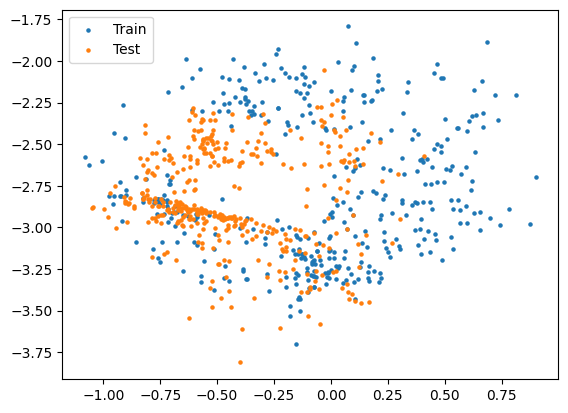

In [41]:
plt.scatter(X_fit[:n_train, 0], X_fit[:n_train, 1], s=5, label='Train')
plt.scatter(X_fit[n_train:, 0], X_fit[n_train:, 1], s=5, label='Test')
plt.legend()
plt.show()

Some of the test data is spread close to points in the training data. However, there are also chunks of test data that are in the middle of sparse bits of training data, which likely the model has not seen before.

In [47]:
labels = np.loadtxt(data_files[0], delimiter=",", max_rows=1, dtype=str).tolist()
labels = labels[2:]  # Don't need label and timestamp labels

['emg_right_ta',
 'emg_left_ta',
 'emg_right_gs',
 'ecg',
 'eog',
 'left_shank_accel_x',
 'left_shank_accel_y',
 'left_shank_accel_z',
 'left_shank_gyro_x',
 'left_shank_gyro_y',
 'left_shank_gyro_z',
 'right_shank_accel_x',
 'right_shank_accel_y',
 'right_shank_accel_z',
 'right_shank_gyro_x',
 'right_shank_gyro_y',
 'right_shank_gyro_z',
 'waist_accel_x',
 'waist_accel_y',
 'waist_accel_z',
 'waist_gyro_x',
 'waist_gyro_y',
 'waist_gyro_z',
 'arm_accel_x',
 'arm_accel_y',
 'arm_accel_z',
 'arm_gyro_x',
 'arm_gyro_y',
 'arm_gyro_z',
 'arm_skin_conductance']

array([ 1.22610876,  1.22328863,  1.21281387,  1.19790749,  1.18400829,
        1.17595079,  1.17393641,  1.17715941,  1.1830011 ,  1.18864136,
        1.19065573,  1.18682842,  1.17937523,  1.16990766,  1.16124584,
        1.15681421,  1.15520271,  1.15661278,  1.15862715,  1.15903003,
        1.15741853,  1.15338977,  1.14795096,  1.14190783,  1.13868483,
        1.13566326,  1.13485751,  1.1342532 ,  1.13284313,  1.13042588,
        1.12639713,  1.12176406,  1.11813819,  1.1155195 ,  1.11370656,
        1.113908  ,  1.11310225,  1.11108787,  1.10766343,  1.10303037,
        1.09799442,  1.0935628 ,  1.09054123,  1.08913117,  1.08973548,
        1.09033979,  1.08913117,  1.08651248,  1.08187941,  1.07664204,
        1.06999459,  1.0657644 ,  1.06314571,  1.06334715,  1.06455578,
        1.0657644 ,  1.06395147,  1.06153421,  1.05629684,  1.05005227,
        1.04400914,  1.03998039,  1.03695882,  1.03836889,  1.03977895,
        1.04038326,  1.03957751,  1.03655595,  1.03051282,  1.02

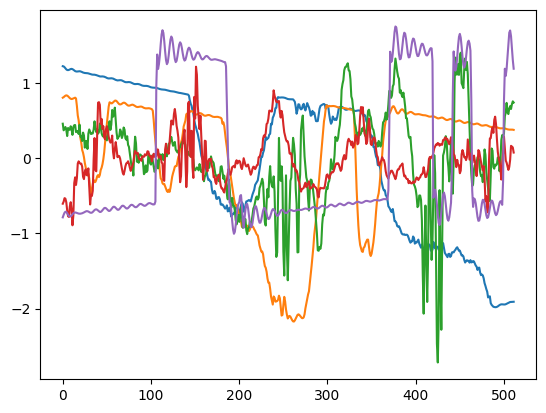

In [59]:
plt.plot(np.array(train_vecs).T)

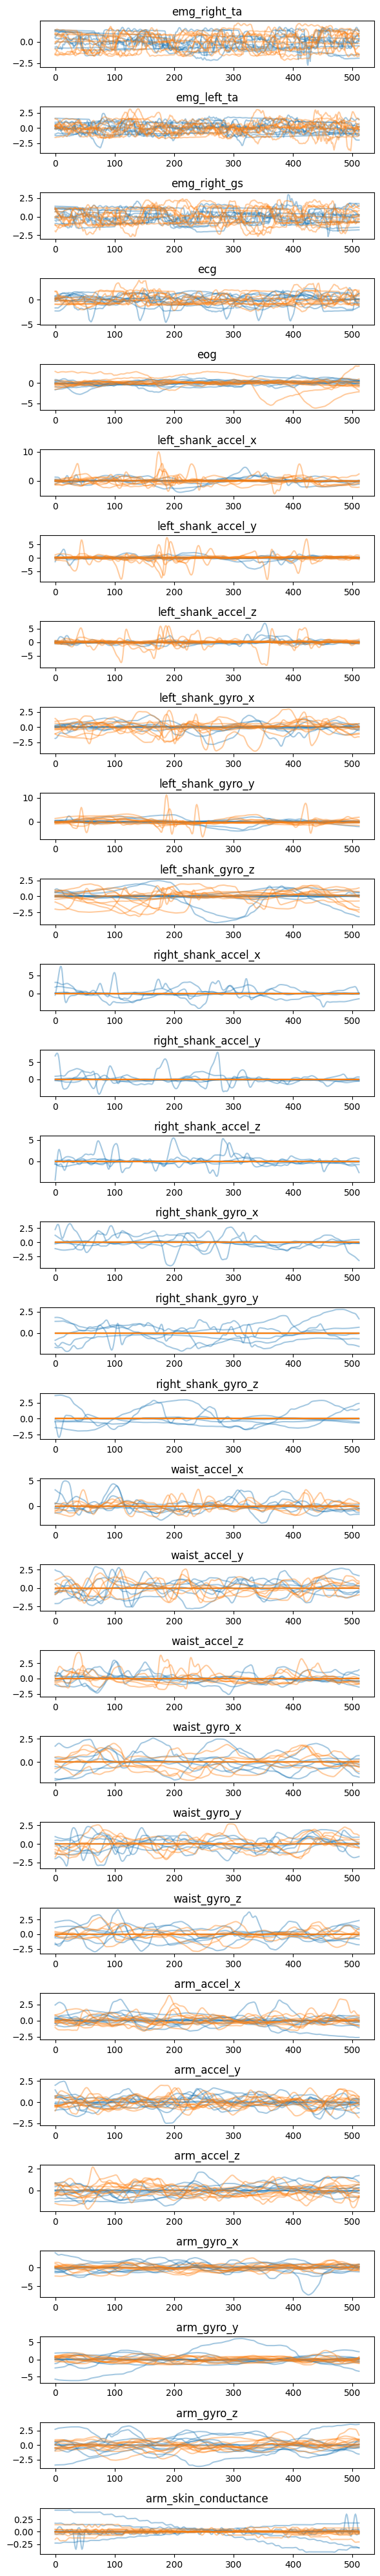

In [63]:
# Plot all the channels to see if there are any major outliers
fig, axs = plt.subplots(30, 1, figsize=(6, 40))

for i, (ax, label) in enumerate(zip(axs, labels)):
    train_vecs = [x[:, i].flatten() for x in mts_list[:10]]
    train_vecs = np.array(train_vecs).T
    test_vecs = [x[:, i].flatten() for x in mts_list[-10:]]
    test_vecs = np.array(test_vecs).T
    ax.plot(train_vecs, c="C0", alpha=0.4)
    ax.plot(test_vecs, c="C1", alpha=0.4)
    ax.set_title(label)
plt.tight_layout()

Test data looks to be missing right shank IMU data.

In [64]:
# Check the raw stats
import pickle
with open("/root/trevor/syde599/norm_fog_data/raw_stats.pkl", "rb") as f:
    raw_stats = pickle.load(f)

In [66]:
subject_1 = {k: v for k, v in raw_stats.items() if "001" in k}
subject_5 = {k: v for k, v in raw_stats.items() if "005" in k}
subject_7 = {k: v for k, v in raw_stats.items() if "007" in k}

In [72]:
[i for i, label in enumerate(labels) if "right_shank" in label or "waist" in label]

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [69]:
for subject in [subject_1, subject_5, subject_7]:
    for task_key, v in subject.items():
        valid_sensors = list(v.keys())
        invalid_sensors = [s for s in labels if s not in valid_sensors]
        print(task_key)
        print(invalid_sensors)

001_task_1.csv
['right_shank_accel_x', 'right_shank_accel_y', 'right_shank_accel_z', 'right_shank_gyro_x', 'right_shank_gyro_y', 'right_shank_gyro_z']
001_task_2.csv
['right_shank_accel_x', 'right_shank_accel_y', 'right_shank_accel_z', 'right_shank_gyro_x', 'right_shank_gyro_y', 'right_shank_gyro_z']
001_task_3.csv
['right_shank_accel_x', 'right_shank_accel_y', 'right_shank_accel_z', 'right_shank_gyro_x', 'right_shank_gyro_y', 'right_shank_gyro_z']
001_task_4.csv
['right_shank_accel_x', 'right_shank_accel_y', 'right_shank_accel_z', 'right_shank_gyro_x', 'right_shank_gyro_y', 'right_shank_gyro_z']
005_task_1.csv
['right_shank_accel_x', 'right_shank_accel_y', 'right_shank_accel_z', 'right_shank_gyro_x', 'right_shank_gyro_y', 'right_shank_gyro_z', 'waist_accel_x', 'waist_accel_y', 'waist_accel_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z']
005_task_2.csv
['right_shank_accel_x', 'right_shank_accel_y', 'right_shank_accel_z', 'right_shank_gyro_x', 'right_shank_gyro_y', 'right_shank_gyro